In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)


t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val



In [4]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[3.5149],
        [5.5933]], grad_fn=<AddmmBackward0>)

In [6]:
t_un_val

tensor([[5.8200],
        [4.8900]])

In [4]:
# Model has just one feature, so just weight and bias
linear_model.weight

Parameter containing:
tensor([[-0.6344]], requires_grad=True)

In [5]:
linear_model.bias

Parameter containing:
tensor([-0.6675], requires_grad=True)

In [7]:
x = torch.ones(1)
linear_model(x)

tensor([-1.3019], grad_fn=<ViewBackward0>)

In [10]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-1.3019],
        [-1.3019],
        [-1.3019],
        [-1.3019],
        [-1.3019],
        [-1.3019],
        [-1.3019],
        [-1.3019],
        [-1.3019],
        [-1.3019]], grad_fn=<AddmmBackward0>)

In [8]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):

  for epoch in range(1, n_epochs+1):
    t_p_train = model(t_u_train)
    loss_train = loss_fn(t_p_train, t_c_train)

    t_p_val = model(t_u_val)
    loss_val = loss_fn(t_p_val, t_c_val)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch % 1000 == 0:
      print(f'Epoch: {epoch}, Training Loss {loss_train.item():.4f},'
            f'Validation Loss {loss_val.item():.4f}')


In [32]:

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch: 1000, Training Loss 4.5200,Validation Loss 10.7336
Epoch: 2000, Training Loss 2.8780,Validation Loss 5.2495
Epoch: 3000, Training Loss 2.7448,Validation Loss 4.7415

Parameter containing:
tensor([[5.2424]], requires_grad=True)
Parameter containing:
tensor([-17.0296], requires_grad=True)


In [33]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [34]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [6]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 13)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(13, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [39]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

hidden_linear.weight torch.Size([13, 1])
hidden_linear.bias torch.Size([13])
output_linear.weight torch.Size([1, 13])
output_linear.bias torch.Size([1])


In [9]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 13)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(13, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print('output: ', seq_model(t_un_val))
print('answer: ', t_c_val)

Epoch: 1000, Training Loss 3.2930,Validation Loss 4.5008
Epoch: 2000, Training Loss 2.6051,Validation Loss 8.7685
Epoch: 3000, Training Loss 1.8536,Validation Loss 6.9191
output:  tensor([[ 1.6901],
        [14.8302]], grad_fn=<AddmmBackward0>)
answer:  tensor([[ 0.5000],
        [13.0000]])


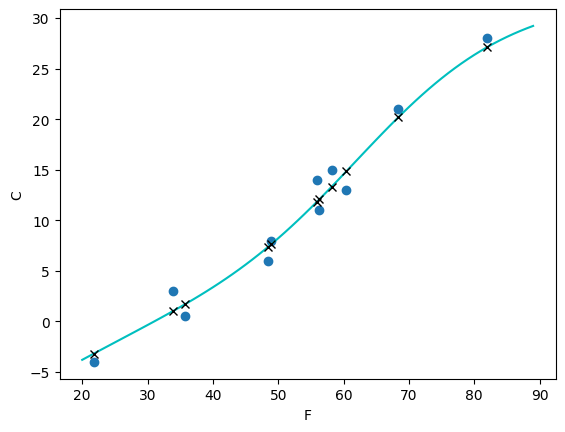

In [10]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure()
plt.xlabel('F')
plt.ylabel('C')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')